# Mode fitting

Here we will make a simple hierarchical model that encodes some knowledge of quasi-equally spaced modes of oscillation into the prior.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

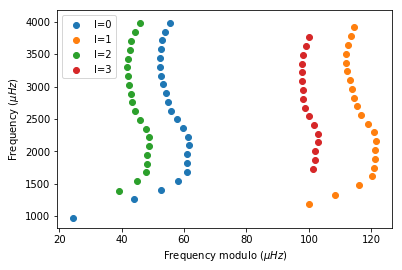

In [51]:
dnu_sol = 136e-6  # book value of large freq separation for the sun

df = pd.read_table('broomhall2009.txt', delim_whitespace=True, names=('n', 'l', 'nu', 'nu_unc'))  #import data

lmodes = []
dnu_avg = []
f_mod = []

for i in range(4):
    lmodes.append(df[df.l == i])
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

The lower departure from a straight line is due to the BCZ, so the lower frequencies are not useful in analysing the response from the HeII ionization zone. Frequencies below 1700 $\mu$Hz are omitted.

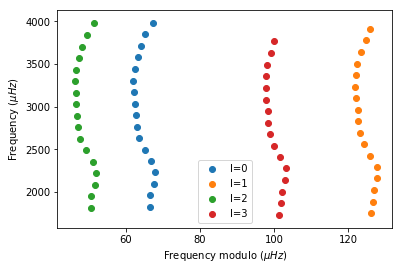

In [52]:
for i in range(4):
    lmodes[i] = lmodes[i].loc[lmodes[i].nu > 1700]
    lmodes[i] = lmodes[i].set_index(np.arange(0,len(lmodes[i]),1))

dnu_avg = []
f_mod = []
for i in range(4):
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

Text(0, 0.5, 'Frequency modulo ($\\mu Hz$)')

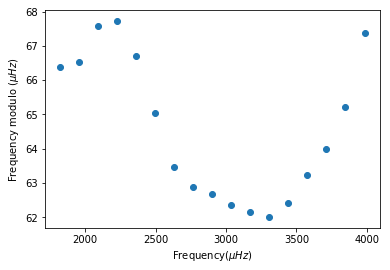

In [53]:
plt.scatter(lmodes[0].nu, f_mod[0])
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'Frequency modulo ($\mu Hz$)')

This analysis will use the methods detailed in Vrard 2015 and, as such, will use its definitions.

The definition for the local frequency spacing is:

$\Delta\nu(n) = \frac{\nu_{n+1,0}-\nu_{n-1,0}}{2}$.

At the edges of the measured radial modes, we cannot use this equation and replace it by the frequency difference between two consecutive radial modes.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, '$(\\nu_{n+1,0}-\\nu_{n-1,0})/2$ ($\\mu Hz$)')

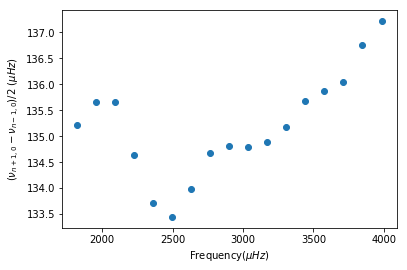

In [80]:
lmodes[0]['dnu_n'] = (lmodes[0]['nu'].diff(2).shift(-1)/2)
lmodes[0]['dnu_n'][0] = lmodes[0]['nu'].diff(1)[1]
lmodes[0]['dnu_n'][16] = (lmodes[0]['nu'].diff(1)[16])

plt.scatter(lmodes[0].nu, lmodes[0].dnu_n)
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'$(\nu_{n+1,0}-\nu_{n-1,0})/2$ ($\mu Hz$)')

We assume the frequency with largest amplitude is at $n=22$ meaning $\nu_{max} = 3168.618$. This is then used in the determination of the universal pattern to which the frequency separation will be compared:

$\Delta\nu_{UP}(n)=(1+\alpha(n-n_{max}))\langle\Delta\nu\rangle$

We compute the difference between the observed local large separation and the theoretical local large separation predicted by the universal pattern:

$\delta_{g,obs}=\Delta\nu(n)-\Delta\nu_{UP}(n)$

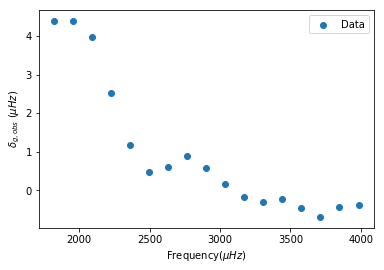

In [144]:
nmax = 22
numax = 3168.618
alpha = 0.015*dnu_avg[0]**(-0.32)
dnu_UP = (1+alpha*(lmodes[0].n-nmax))*dnu_avg[0]
deltag = lmodes[0].dnu_n - dnu_UP

plt.scatter(lmodes[0].nu, deltag, label='Data')
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'$\delta_{g,obs}$ ($\mu Hz$)')
plt.legend()

In [145]:
0.06*dnu_avg[0]**-0.88

0.0008003460587489702

The amplitude can be found by fitting an oscillatory component to the resultant frequency variations obtained after removal of the curvature term from the measurements:

$\delta_{g,obs}=\mathcal{A}\langle\Delta\nu\rangle cos\big(\frac{2\pi(\nu-\nu_{max})}{\mathcal{G}\langle\Delta\nu\rangle}+\phi\big)$

where $\mathcal{G}$ is the period of the oscillation expressed in units of $\langle\Delta\nu\rangle$, $\mathcal{A}$ is the amplitude of the oscillation in units of $\langle\Delta\nu\rangle$ and $\phi$ is the phase of the oscillation centered on $\nu_{max}$.

In [153]:
code = '''
functions {
    real dgobs(real A, real numax, real nu, real G, real phi){
        return A * cos((2*pi()*(nu-numax))/G + phi);
    }
}
data {
    int N; // Data points per order
    real nu[N];
    real numax;
    real dnu_avg;
    real dg[N];
}
parameters {
    real G;
    real A;
    real phi;
}
model {
    vector[N] mod;
    A ~ normal(0.06*dnu_avg^(-0.88), 0.01);
    G ~ normal(4*dnu_avg, 2);
    phi ~ normal(pi(), 1);
    for (i in 1:N) mod[i] = dgobs(A, numax, nu[N], G, phi);
    mod ~ normal(dg, 2);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d85bed388910ebb09c3bd0e59615a8b NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpwxd8obd5/stanfit4anon_model_2d85bed388910ebb09c3bd0e59615a8b_8767489412278834229.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


The code takes a while to converge.  We run for 20000 iterations and check the results.

In [147]:
stan_data = {'N': len(lmodes[0]), 
             'nu': lmodes[0].nu, 'dg': deltag,
             'numax': numax, 'dnu_avg': dnu_avg[0]}
nchains = 4
#start = {'dnu': dnu, 'numax': numax}
fitsm = sm.sampling(data=stan_data, iter=20000, chains=nchains) #init=[start for n in range(nchains)])

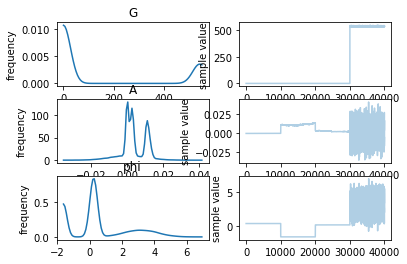

In [148]:
fitsm.plot()
plt.show()

In [149]:
print(fitsm)

Inference for Stan model: anon_model_63e2d2f9b8d13df700234326e6a5aa42.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
G    135.05  165.41 233.93-9.3e-3-5.8e-3-9.6e-4 292.25 542.83      2 247.32
A    3.8e-3  3.4e-3 6.7e-3  -0.01 6.2e-5 2.4e-3   0.01   0.01      4   1.39
phi    0.51    1.22   1.78  -1.62  -1.24   0.14   0.35   4.43      2   3.79
lp__ -2.7e4   1.1e4  1.6e4 -3.7e4 -3.7e4 -3.6e4 -1.6e4  -8.42      2  2.8e4

Samples were drawn using NUTS at Tue Nov 27 17:31:57 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


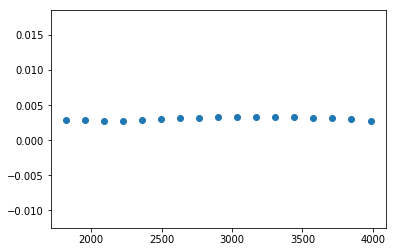

In [150]:
dgstan = fitsm['A'].mean() * np.cos((2*3.14159*(lmodes[0].nu-numax))/fitsm['G'].mean() + fitsm['phi'].mean())

fig, ax = plt.subplots()
ax.scatter(lmodes[0].nu, dgstan)

Here is a corner plot of the results:

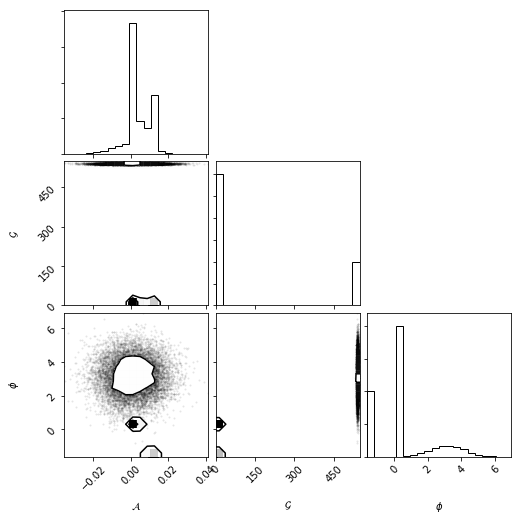

In [151]:
import corner
data = np.vstack([fitsm['A'], fitsm['G'], fitsm['phi']]).T
corner.corner(data, labels=[r'$\mathcal{A}$', r'$\mathcal{G}$', r'$\phi$'])
plt.show()

From Nature volume 215, pages 43–44 (01 July 1967) the helium mass fraction of the sun is between 0.20 and 0.27.